<a href="https://colab.research.google.com/github/usercivil/program/blob/main/auto_KRS_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!git clone https://github.com/usercivil/program.git 

fatal: destination path 'program' already exists and is not an empty directory.


In [4]:
%cd program
!bash auto_KRS.sh
import auto_KRS

/content/program


chrome is opened successfully


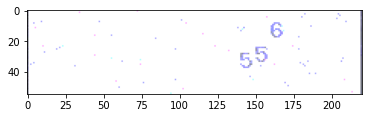

In [ ]:
#author: Defit Tri H
username = 'username Simaster'
password = 'password Simaster'
matkul_kelas = [['TKSS213201',2],  ['TKSS213106',2]]

auto_KRS = auto_KRS.auto_KRS()
auto_KRS.login(username, password)
auto_KRS.display_login_capt()


In [ ]:
auto_KRS.solve_login_capt()
auto_KRS.open_KRS_page()
# auto_KRS.war_KRS(matkul_kelas)

solve captcha: 556


In [ ]:
auto_KRS.save_screenshot('simaster.png')

In [ ]:
auto_KRS.close()
